# Lab 1 - K-Nearest Neighbours
(TEAM WORK): SOMAYYEH ESLAMI AND MARYAM BAGHERIRAD
This lab is about the implementation and analysis of the KNN algorithm for classification problems

In [3]:
### If you use colab uncomment these line and upload Material.zip

#from google.colab import files

#files.upload()
#!unzip Material.zip

In [5]:
# Packages used
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
import os
import pickle
np.random.seed(100)

### Data generation for binary classification

We start generating a training set for binary classification problems. Consider the following function, that generates random 2D points on the plane and assigns them a binary label according to their position w.r.t. a linear separator.

The function `linearBinaryClass`, given a sample size `n`, lower and upper bounds `low_D, high_D` for the domain of the samples and the linear function parameters `m, q`, generates a binary classification dataset i.e. it returns `X` and `Y`.

The signature of the function is the following:

`X, Y = linearBinaryClass(n, low_D, high_D, m, q)`

where
- **n** is the number of samples to be generated
- **low_D** and **high_D** are, respectively, the lower and upper bounds for the domain of the samples i.e.
    $$
    X_{i,j} \sim \mathcal{U}(\text{low_D}, \text{high_D})
    $$
- **m, q** are the linear function parameters
- **X**, **Y**: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)


In [7]:
def linearBinaryClass(n, low_D, high_D, m, q):
    X = (np.random.rand(n, 2) * (high_D - low_D)) + low_D
    Y = np.sign((X[:,1] - (m * X[:,0]) + q))
    Y[Y==0] = 1
    return X,Y

### Computing the distance between input points

In order to build the KNN estimator we need to resort to a distance function.

Consider a function that computes the euclidean distance between two points...

In [11]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

... and then a function that computes all the distance between two set of points stored in two matrices.

In [14]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

The usage is the following:

**D = allDistances(X1,X2)**

where
- **X1** is a matrix of size $n_1 \times D$, where each row is a D-dimensional point
- **X2** is a matrix of size $n_2 \times D$, where each row is a D-dimensional point
- **D** is a matrix of size $n_1 \times n_2$, where each element `D[i,j]` is the distance between points (`X1[i, :]`, `X2[j, :]`)

### Adding noise to the samples

To make the task harder, we may want to perturb the labels with some noise.

In our case, we have binary labels and a common way of adding noise is to flip the value of a small percentage of the labels. For example, if a label was $+1$ it will become $-1$.

The `flipLabels` function takes two arguments:
 - `Y`, the numpy array of original labels
 - `P`, an integer between 1 and 100 specifying the percentage of labels which will be flipped
and returns an array of the same shape as `Y`, which contains the noisy labels.


In [18]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        raise Exception('P should be between 1 and 100')
        
    indices_to_flip = np.random.choice(range(len(Y)), int(len(Y) * (P / 100)), replace=False)
    Y_noisy = Y.copy()
    Y_noisy[indices_to_flip] *= -1
    
    return Y_noisy


### Assignment 1: The KNN classifier

We are now ready to use the KNN algorithm to estimate the classification function. 

Implement the `kNNClassify` function which train a KNN classifier on given training set and returns predictions on a given test set. 

The signature of the function is the following:

`Ypred = kNNClassify(Xtr, Ytr, k, Xte)`

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered
- **Xte** is a matrix of size [nte, D], where each row is a D-dimensional point (INPUT IN THE **TEST SET**)
- **Ypred** is an array of size [nte], where each element is a binary label (ESTIMATED OUTPUT FOR THE **TEST SET**)

where [ntr] and [nte] are respectively the number of points in the training set and the number of points in the test set

In [21]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0] # number of the test inputs

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from TEST input and TRAINING input
    dist = np.zeros((n_test, n_train))
    for i in range(n_test):
        dist[i, :] = np.linalg.norm(Xtr - Xte[i, :], axis=1)
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):
        nearest_indices = np.argsort(dist[idx])[:k]  # ایندکس‌های k همسایه نزدیک
        nearest_labels = Ytr[nearest_indices]  # برچسب‌های همسایگان نزدیک

        # Hint 1: take all the distances for the current test point
        # Hint 2: Sort the indices of the distances
        # Hint 3: Get the indices of the k lowest of distances
        # Hint 4: Compute the mean of the output values of the corresponding training points and taking the sign of it.
        
        Ypred[idx] = np.sign(np.mean(nearest_labels))
    return Ypred


### Visualizing the separating function

The visualization of the separating function on the training set, i.e. the function estimated by classification algorithm for discriminating between classes, is of benefit for appreciating the behavior of the binary classifier. To visualize the separating function use the following:

**_separatingFkNN(Xtr, Ytr, k)_**

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered

In [24]:
def separatingFkNN(Xtr, Ytr, k, Xte):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xte)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    plt.subplots()
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    msg = 'Separating function, k='+str(k);
    plt.title(msg)

### Evaluating the goodness of a classifier

To evaluate how good is the classification function estimated by the KNN, we compare the predicted binary labels and expected (true) ones, with the following function:

`err = calcError(Ypred, Ytrue)`

where
- **Ypred** is an array of size $n$, where each element is a binary label predicted by the classifier
- **Ytrue** is an array of size $n$, where each element is the true binary label
- **err** is the fraction of wrongly classified elements wrt the total number


In [27]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

### Assignment 2: Noise-free case

In this assignment, we start to play with the NN classifier. In specific:

- 1.Generate a training set WITHOUT NOISE
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Compute the error on the TRAINING and then on the TEST SET



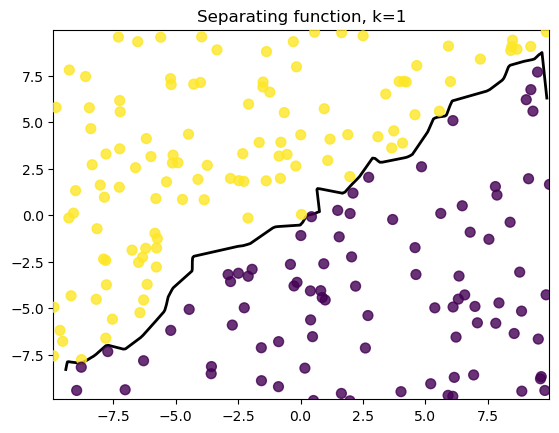

With K=1 the error on the test set is  0.03
With K=1 the error on the training set is  0.0


In [30]:
### Generate training and test sets, build and evaluate the KNN classifier
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

#TODO: Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)  # The separating function uses the same training data to visualize the decision boundary
plt.show()


#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred, Yte)
#print("With K=%d the error on the test set is %.2f%%" % (k, err * 100))

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr =  calcError(Ypredtr, Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

### Assignment 3: adding noise

Keeping the parameters of the function and the number of points as in the previous assignment:

- 1.Generate a training set WITH NOISE (for instance with 10% of flipped labels)
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Evaluate the NN classifier on the TRAINING and on the TEST SET
- 5.Compute the obtained error on the TRAINING and on the TEST SET

- Repeat the steps from 1 to 5 with the **KNN** algorithm, setting for instance K=5

OBSERVE WHAT CHANGES...

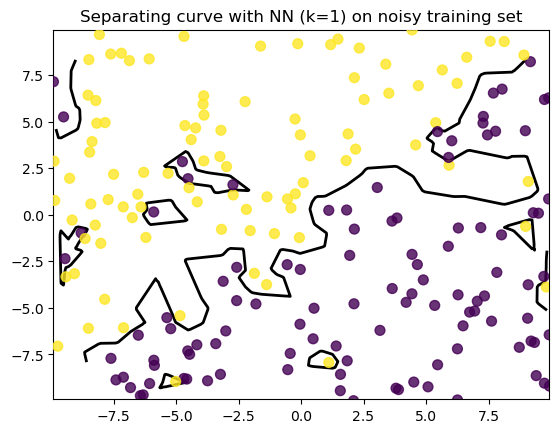

NN classifier (k=1) error on training set: 0.00%
NN classifier (k=1) error on test set: 19.00%


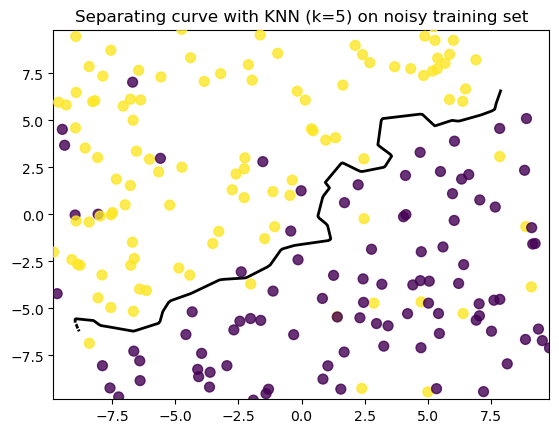

KNN classifier (k=5) error on training set: 11.50%
KNN classifier (k=5) error on test set: 14.50%


In [33]:
# ... your code goes here... #
# Parameters
n = 200  # number of points
D = 2  # dimensionality
m = 0.9  # slope of the separating line
q = 0.0  # y-intercept of the separating line
low_D = -10  # lower bound for the domain
high_D = 10  # upper bound for the domain
noise_percentage = 10  # 10% noise in labels

# 1. Generate a training set WITH NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Ytr_noisy = flipLabels(Ytr, noise_percentage)  # Add noise (10% of labels flipped)

# 2. Visualize the separating curve for the NN classifier (k=1)
separatingFkNN(Xtr, Ytr_noisy, k=1, Xte=Xtr)  # Visualize NN classifier (k=1)
plt.title("Separating curve with NN (k=1) on noisy training set")
plt.show()

# 3. Generate a test set with the same amount of noise as the training set
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
Yte_noisy = flipLabels(Yte, noise_percentage)  # Add noise to the test set

# 4. Evaluate the NN classifier on the TRAINING SET (k=1)
Ypred_tr_nn = kNNClassify(Xtr, Ytr_noisy, k=1, Xte=Xtr)
err_tr_nn = calcError(Ypred_tr_nn, Ytr_noisy)

# Evaluate the NN classifier on the TEST SET (k=1)
Ypred_te_nn = kNNClassify(Xtr, Ytr_noisy, k=1, Xte=Xte)
err_te_nn = calcError(Ypred_te_nn, Yte_noisy)

print("NN classifier (k=1) error on training set: %.2f%%" % (err_tr_nn * 100))
print("NN classifier (k=1) error on test set: %.2f%%" % (err_te_nn * 100))

# 5. Repeat the above steps for KNN classifier (k=5)

# 1. Generate training set WITH NOISE (same as before)
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Ytr_noisy = flipLabels(Ytr, noise_percentage)

# 2. Visualize the separating curve for KNN classifier (k=5)
separatingFkNN(Xtr, Ytr_noisy, k=5, Xte=Xtr)  # Visualize KNN classifier (k=5)
plt.title("Separating curve with KNN (k=5) on noisy training set")
plt.show()

# 3. Generate a test set with the same amount of noise
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
Yte_noisy = flipLabels(Yte, noise_percentage)

# 4. Evaluate the KNN classifier on the TRAINING SET (k=5)
Ypred_tr_knn = kNNClassify(Xtr, Ytr_noisy, k=5, Xte=Xtr)
err_tr_knn = calcError(Ypred_tr_knn, Ytr_noisy)

# Evaluate the KNN classifier on the TEST SET (k=5)
Ypred_te_knn = kNNClassify(Xtr, Ytr_noisy, k=5, Xte=Xte)
err_te_knn = calcError(Ypred_te_knn, Yte_noisy)

print("KNN classifier (k=5) error on training set: %.2f%%" % (err_tr_knn * 100))
print("KNN classifier (k=5) error on test set: %.2f%%" % (err_te_knn * 100))


Describe here what changes: this code demonstrates the comparison between NN (k=1) and KNN (k=5) classifiers in a binary classification task. The steps include generating noisy training and test sets, visualizing the separating curves for each classifier, and evaluating their performance. The NN classifier typically overfits the training set, showing lower training error but higher test error, while the KNN classifier with k=5 smooths the decision boundary, improving test set performance.








### Assignment 4

Analyse the performance of the **KNN** with plots, considering in particular the following:



- **SCENARIO 1**: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the value of K

- **SCENARIO 2**: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise

- **SCENARIO 3**: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

For each scenario, describe what happen

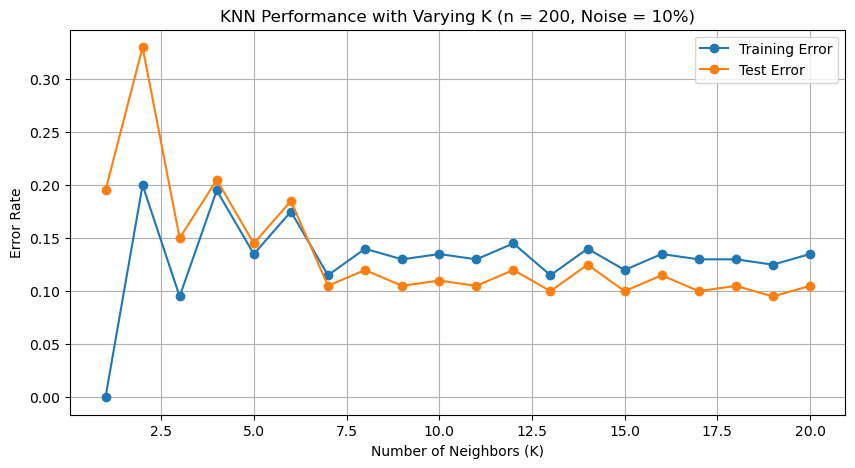

In [37]:
# SCENARIO 1: Varying K (Number of Neighbors)
def scenario1():
    n = 200  # Number of points
    noise = 10  # 10% noise
    Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
    Ytr_noisy = flipLabels(Ytr, noise)

    Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
    Yte_noisy = flipLabels(Yte, noise)

    k_values = range(1, 21)  # Varying K from 1 to 20
    training_errors = []
    test_errors = []

    for k in k_values:
        Ypred_tr = kNNClassify(Xtr, Ytr_noisy, k, Xtr)
        err_tr = calcError(Ypred_tr, Ytr_noisy)
        training_errors.append(err_tr)

        Ypred_te = kNNClassify(Xtr, Ytr_noisy, k, Xte)
        err_te = calcError(Ypred_te, Yte_noisy)
        test_errors.append(err_te)

    plt.figure(figsize=(10, 5))
    plt.plot(k_values, training_errors, label='Training Error', marker='o')
    plt.plot(k_values, test_errors, label='Test Error', marker='o')
    plt.title('KNN Performance with Varying K (n = 200, Noise = 10%)')
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
scenario1()



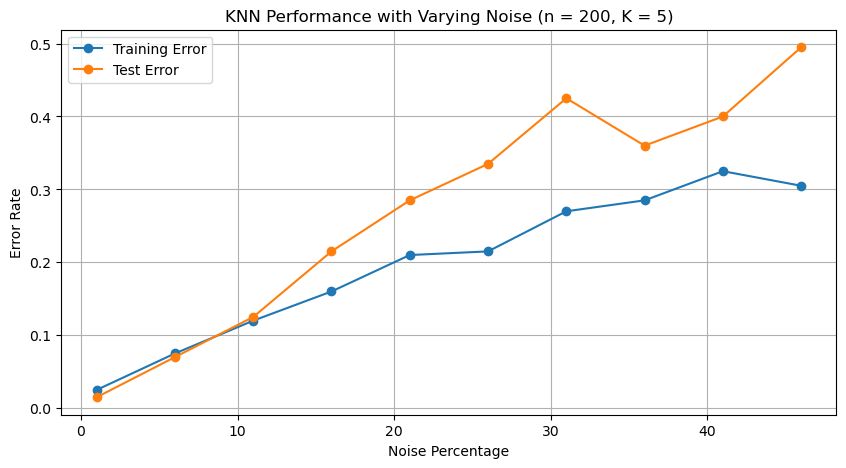

In [38]:
# SCENARIO 2: Varying Noise
def scenario2():
    n = 200  # Number of points
    k = 5  # Set K to a reasonable value
    noise_percentages = range(1, 51, 5)  # Varying noise from 1% to 50%
    
    training_errors = []
    test_errors = []

    for noise in noise_percentages:
        Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
        Ytr_noisy = flipLabels(Ytr, noise)

        Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
        Yte_noisy = flipLabels(Yte, noise)

        Ypred_tr = kNNClassify(Xtr, Ytr_noisy, k, Xtr)
        err_tr = calcError(Ypred_tr, Ytr_noisy)
        training_errors.append(err_tr)

        Ypred_te = kNNClassify(Xtr, Ytr_noisy, k, Xte)
        err_te = calcError(Ypred_te, Yte_noisy)
        test_errors.append(err_te)

    plt.figure(figsize=(10, 5))
    plt.plot(noise_percentages, training_errors, label='Training Error', marker='o')
    plt.plot(noise_percentages, test_errors, label='Test Error', marker='o')
    plt.title('KNN Performance with Varying Noise (n = 200, K = 5)')
    plt.xlabel('Noise Percentage')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run Scenario 2
scenario2()


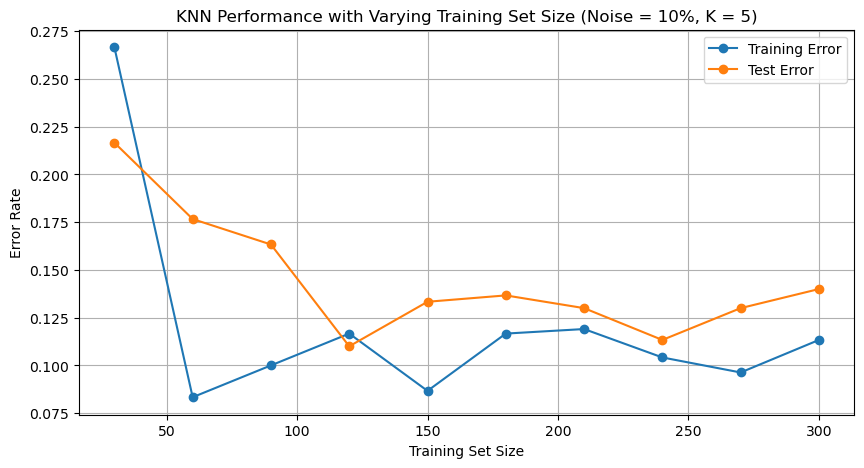

In [40]:
# SCENARIO 3: Varying Training Set Size
def scenario3():
    noise = 10  # Fixed noise
    k = 5  # Fixed K
    n_values = range(30, 301, 30)  # Varying training set size from 30 to 300
    test_size = 300  # Fixed test set size

    training_errors = []
    test_errors = []

    for n in n_values:
        Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
        Ytr_noisy = flipLabels(Ytr, noise)

        Xte, Yte = linearBinaryClass(test_size, low_D, high_D, m, q)
        Yte_noisy = flipLabels(Yte, noise)

        Ypred_tr = kNNClassify(Xtr, Ytr_noisy, k, Xtr)
        err_tr = calcError(Ypred_tr, Ytr_noisy)
        training_errors.append(err_tr)

        Ypred_te = kNNClassify(Xtr, Ytr_noisy, k, Xte)
        err_te = calcError(Ypred_te, Yte_noisy)
        test_errors.append(err_te)

    plt.figure(figsize=(10, 5))
    plt.plot(n_values, training_errors, label='Training Error', marker='o')
    plt.plot(n_values, test_errors, label='Test Error', marker='o')
    plt.title('KNN Performance with Varying Training Set Size (Noise = 10%, K = 5)')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
scenario3()


Insert here your observations:
- **SCENARIO 1**
- As the number of neighbors (k) increases, both training and test errors decrease and stabilize.
For small k: The model is more affected by outliers and noise, leading to higher errors.
As k increases: The model smooths out its decision, reducing errors, but too large k might make it too simple and cause errors to increase again slightly.
so Small k leads to overfitting, larger k improves generalization, but too large k can lead to underfitt
n- **SCENARIO 2**
As noise increases, both training and test errors rise.

- training error: When noise is added (by switching labels), the model tries to fit the incorrect labels, leading to more mistakes and a gradual increase in error.
- : As the noisetest error : level grows, the model struggles to generalize to new data, causing test error to rise. This is because the test set has the same level of noise, making it harder for the model to identify patterns.

so Noise makes classification more challenging. The more noise there is, the worse the model performs on both training and test sets. However, increasing k (as described in Scenario 1) can help the model reduce the effect of noise by considering more data points, making it less sensitive to individual noisy points.
ts.
- **SCENARIO 3**:Varying Training Set Size (Fixed Noise = 10%As the number of training samples increases: The performance of the KNN classifier on both the training and test sets improves.
Training error: With more training samples, the model can learn the decision boundary better, reducing the training error.
Test error: Increasing the number of training samples allows the classifier to generalize better, leading to a decrease in test error. More training data gives the classifier more information to refine its decision boundary, leading to better performance.
Key takeaway: Having more training data improves the performance of KNN, especially on the test set. This is because KNN benefits from having more examples to accurately identify the correct neighbors and make more reliable predictions.
ictions.
